In [2]:
import torch
import gymnasium as gym
import random
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import numpy as np
import os
import time

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
print(f"Using device: {DEVICE}")

Using device: cuda:0


In [4]:
replayItem = namedtuple('replayItem', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayMemory:
    def __init__(self, capacity) -> None:
        self.memory = deque(maxlen=capacity)

    def append(self, *args) -> None:
        self.memory.append(replayItem(*args))

    def sample(self, batch_size, device) -> list:
        if len(self.memory) < batch_size:
            samples = [random.choice(self.memory) for _ in range(batch_size)]
        else:
            samples = random.sample(self.memory, batch_size)

        reshaped_items = tuple(map(np.stack, zip(*samples)))
        result = tuple(map(lambda x: torch.from_numpy(x).to(device), reshaped_items))

        return result
    
    def __len__(self) -> int:
        return len(self.memory)

import reverb

class ReverbMemory:
    def __init__(self, capacity) -> None:
        self.table_name = 'priority_table'
        self.server = reverb.Server(tables=[
            reverb.Table(
                name=self.table_name,
                sampler=reverb.selectors.Uniform(),
                remover=reverb.selectors.Fifo(),
                max_size=capacity,
                rate_limiter=reverb.rate_limiters.MinSize(1),
            )
        ])
        self.writer_client = reverb.client.Client(f'localhost:{self.server.port}')
        self.reader_client = reverb.client.Client(f'localhost:{self.server.port}')

    def append(self, *args) -> None:
        self.writer_client.insert(replayItem(*args), priorities={self.table_name: 1.0})

    def sample(self, batch_size, device) -> tuple[np.ndarray,...]:
        samples = self.reader_client.sample(self.table_name, num_samples=batch_size)
        result = [sample[0].data for sample in samples]

        reshaped_items = tuple(map(np.stack, zip(*result)))
        result = tuple(map(lambda x: torch.from_numpy(x).to(device), reshaped_items))

        return result

    def __len__(self) -> int:
        return self.writer_client.server_info()['priority_table'].current_size

In [5]:
class DQN(torch.nn.Module):
    def __init__(self, layer_sizes) -> None:
        super().__init__()
        self.layers = torch.nn.Sequential()
        for i in range(len(layer_sizes)-1):
            self.layers.add_module(f'layer{i}', torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                self.layers.add_module(f'relu{i}', torch.nn.LeakyReLU())

    def forward(self, x)->torch.Tensor:
        return self.layers(x)

In [6]:
def epsilon_greedy_action(epsilon, action_rewards, device)->torch.Tensor:
    if random.random() < epsilon:
        return torch.randint(0, len(action_rewards), (1,), device=device)
    else:
        return torch.argmax(action_rewards).view((1,)).to(device)

In [7]:
def loss_func(policy_model, target_model, states, actions, rewards, next_states, dones, gamma): 
    actions = actions.view(-1, 1)
    rewards = rewards.view(-1, 1)
    dones = dones.view(-1, 1).int()

    q_values = policy_model.forward(states).gather(1, actions)
    next_q_values = target_model.forward(next_states).max(dim=1, keepdim=True)[0]
    expected_q_values = rewards + gamma * next_q_values * (1 - dones)
    loss = torch.nn.functional.mse_loss(q_values, expected_q_values)
    return loss

In [8]:
def divmod(x, y):
    return x // y, x % y

def remap_interval(x, f1, f2, t1, t2):
    # map x from [a, b] to [c, d]
    return t1 + (x - f1) * (t2 - t1) / (f2 - f1)

def wrap_pendulum(env, num_actions):    

    def action_remapping(action):
        return remap_interval(action, 0, num_actions-1, -2, 2)

    class PendulumWrapper(gym.Wrapper):
        def __init__(self, env) -> None:
            super().__init__(env)

        def step(self, action):
            action_remapped = action_remapping(action)
            return self.env.step(action_remapped)
        
    return PendulumWrapper(env)


def wrap_swimmer(env, num_actions):
    # Check num action is a square number
    sqrt_actions = num_actions ** 0.5
    assert int(sqrt_actions) == sqrt_actions
    
    def action_remapping(action):
        # remapping the single action to 2 actions
        # action = 0 -> (0, 0), action = 1 -> (1, 0), etc
        a1, a2 = divmod(action, sqrt_actions)
        real_a1 = remap_interval(a1, 0, sqrt_actions-1, -1, 1)
        real_a2 = remap_interval(a2, 0, sqrt_actions-1, -1, 1)
        return np.concatenate([real_a1, real_a2])

    class SwimmerWrapper(gym.Wrapper):
        def __init__(self, env) -> None:
            super().__init__(env)

        def reset(self):
            observation, info = self.env.reset()
            # convert observation to float32
            observation = observation.astype(np.float32)
            return observation, info

        def step(self, action):
            action_remapped = action_remapping(action)
            next_observation, reward, done, trunc, info = self.env.step(action_remapped)
            # convert next_observation to float32
            next_observation = next_observation.astype(np.float32)
            reward = reward.astype(np.float32)
            return next_observation, reward, done, trunc, info

    return SwimmerWrapper(env)


def wrap_half_cheetah(env, num_actions):
    # check if the number can be split into 6 actions
    # get the 6th root of the number
    root = num_actions ** (1/6)
    assert int(root) == root
    
    def action_remapping(action):
        # remapping the single action to 6 actions
        # action = 0 -> (0, 0, 0, 0, 0, 0), action = 1 -> (1, 0, 0, 0, 0, 0), etc
        actions = []
        for i in range(6):
            action, a = divmod(action, root)
            real_a = remap_interval(a, 0, root-1, -1, 1)
            actions.append(real_a)
        return np.concatenate(actions)

    class HalfCheetahWrapper(gym.Wrapper):
        def __init__(self, env) -> None:
            super().__init__(env)

        def reset(self):
            observation, info = self.env.reset()
            # convert observation to float32
            observation = observation.astype(np.float32)
            return observation, info

        def step(self, action):
            action_remapped = action_remapping(action)
            next_observation, reward, done, trunc, info = self.env.step(action_remapped)
            # convert to float32
            next_observation = next_observation.astype(np.float32)
            reward = reward.astype(np.float32)
            return next_observation, reward, done, trunc, info

    return HalfCheetahWrapper(env)

In [9]:
use_wandb = False
if use_wandb:
    import wandb
else:
    class wandb:
        @staticmethod
        def init(*args, **kwargs):
            pass
        @staticmethod
        def log(*args, **kwargs):
            pass
        @staticmethod
        def finish(*args, **kwargs):
            pass

In [10]:
from dataclasses import dataclass

@dataclass
class EnvConfigs:
    env_name: str
    env_creator: callable
    wrapper: callable
    num_episodes: int
    gamma: float
    max_steps: int
    batch_size: int
    epsilon_init: float
    epsilon_min: float
    tau: float
    target_update: int
    memory_capacity: int
    learning_rate: float
    use_reverb: bool
    gradient_clip: float
    hidden_layers: list[int]
    action_space: int

env_to_configs = {
    "gym-pendulum": EnvConfigs(
        env_name="Pendulum-v1",
        env_creator=lambda: gym.make("Pendulum-v1"),
        wrapper=wrap_pendulum,
        num_episodes=200,
        gamma=0.99,
        max_steps=200,
        batch_size=128,
        epsilon_init=1.0,
        epsilon_min=0.01,
        tau=0.001,
        target_update=4,
        memory_capacity=100000,
        learning_rate=1e-4,
        use_reverb=False,
        gradient_clip=1.0,
        hidden_layers=[64, 64],
        action_space=9**1,
    ),
    "gym-swimmer": EnvConfigs(
        env_name="Swimmer",
        env_creator=lambda: gym.make("Swimmer-v4"),
        wrapper=wrap_swimmer,
        num_episodes=200,
        gamma=0.99,
        max_steps=1000,
        batch_size=128,
        epsilon_init=1.0,
        epsilon_min=0.01,
        tau=0.001,
        target_update=4,
        memory_capacity=100000,
        learning_rate=1e-4,
        use_reverb=False,
        gradient_clip=1.0,
        hidden_layers=[64, 64, 64],
        action_space=9**2,
    ),
    "gym-half-cheetah": EnvConfigs(
        env_name="half-cheetah",
        env_creator=lambda: gym.make("HalfCheetah-v4"),
        wrapper=wrap_half_cheetah,
        num_episodes=200,
        gamma=0.99,
        max_steps=1000,
        batch_size=128,
        epsilon_init=1.0,
        epsilon_min=0.01,
        tau=0.001,
        target_update=4,
        memory_capacity=100000,
        learning_rate=1e-4,
        use_reverb=False,
        gradient_clip=1.0,
        hidden_layers=[64, 64, 64],
        action_space=3**6,
    )
}

In [11]:
chosen_env = "gym-pendulum"
config = env_to_configs[chosen_env]

env = config.wrapper(config.env_creator(), config.action_space)

tau = config.tau
gamma = config.gamma
epsilon = config.epsilon_init
epsilon_min = config.epsilon_min
epsilon_steps = 0.5 * config.num_episodes * config.max_steps
epsilon_delta = (epsilon - epsilon_min) / epsilon_steps
batch_size = config.batch_size
memory_size = config.memory_capacity
num_episodes = config.num_episodes
target_update_rate = config.target_update


input_shape = env.observation_space.shape
output_shape = config.action_space
hideen_layers = config.hidden_layers

gradient_clipping_value = config.gradient_clip

model_shape = [*input_shape, *hideen_layers, output_shape]


memory = ReplayMemory(memory_size)
# memory = ReverbMemory(memory_size)
policy_model = DQN(model_shape)
target_model = DQN(model_shape)
target_model.load_state_dict(policy_model.state_dict())
optimizer = torch.optim.Adam(policy_model.parameters(), lr=config.learning_rate)

machine = os.uname().nodename

wandb_config = {
    "type": "Self-Implemented DQN",
    "buffer_type": "Deque" if not config.use_reverb else "Reverb",
    "algorithm": "DQN",
    "enviroment": chosen_env,
    "num_steps": config.max_steps,
    "num_episodes": config.num_episodes,
    "batch_size": config.batch_size,
    "action_space": config.action_space,
    "machine": machine,
}


wandb.init(
    project="Algorithm Comparison",
    config=wandb_config,
)

start_time = time.time()

compile_end_time = time.time()

wandb.log({'compile_time': compile_end_time - start_time})

episode_steps = []
rewards_tracker = []
for i in range(num_episodes):
    state, _ = env.reset()
    steps = 0
    rewards_tracker.append([])
    while True:
        steps+=1
        qs = policy_model.forward(torch.from_numpy(state).to(DEVICE))
        action = epsilon_greedy_action(epsilon, qs, device=DEVICE)
        epsilon = max(epsilon_min, epsilon - epsilon_delta)
        next_observation, reward, done, trunc, info = env.step(action.numpy(force=True))

        next_observation = next_observation.reshape(-1)
        memory.append(state, action.detach().cpu(), reward, next_observation, done)
        state = next_observation
        
        rewards_tracker[-1].append(reward)

        if done or trunc:
            break
        
        # Learning

        batch = memory.sample(batch_size, device=DEVICE)
        states, actions, rewards, next_states, dones = batch
        loss = loss_func(policy_model, target_model, states, actions, rewards, next_states, dones, gamma)
        
        policy_model.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(policy_model.parameters(), gradient_clipping_value)
        optimizer.step()
        
        if steps % target_update_rate == 0:
            for target_param, policy_param in zip(target_model.parameters(), policy_model.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + policy_param.data * tau)
            
    episode_steps.append(steps)
    print(f"Episode {i} finished with reward {sum(rewards_tracker[-1])}")
    wandb.log({'reward': sum(rewards_tracker[-1])})        

execution_time_end = time.time()
wandb.log({'execution_time': execution_time_end - start_time})
wandb.finish()

RuntimeError: Found dtype Double but expected Float

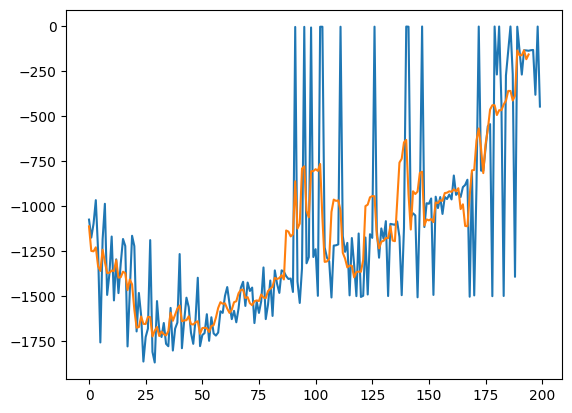

In [ ]:
sums = [sum(rewards) for rewards in rewards_tracker]
plt.plot(sums)
window = 5
plt.plot([sum(sums[i:i+window])/window for i in range(len(sums)-window)])
plt.show()

In [ ]:
# plt.plot(episode_steps)